# Bayesian Markov Random Fields
Supervised foreground image segmentation based on Bauesian MRF.

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from skimage import color, segmentation
from skimage.segmentation import mark_boundaries
import scipy.stats


Loading the original image and scribble mask.

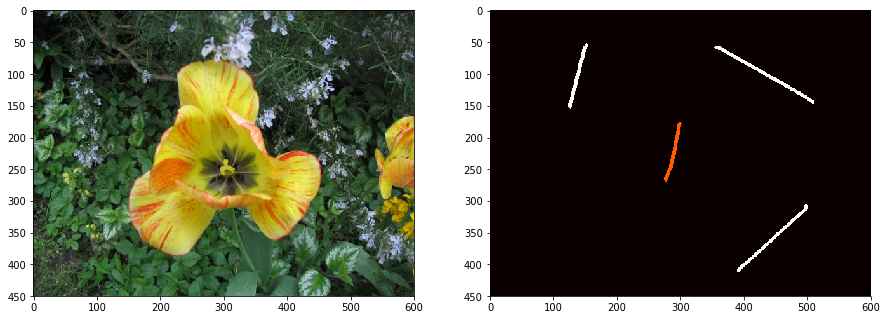

In [ ]:
img = Image.open("flower.jpg")
width, height = img.size
imgdata= np.array(img.getdata()).reshape(height,width,3)

imganno = Image.open("flower-anno.png")
annodata= np.array(imganno.getdata()).reshape(height,width)

fig, ax  = plt.subplots(nrows=1, ncols=2 , figsize=(15, 8))
ax[0].imshow(imgdata )
ax[1].imshow(annodata , cmap='hot')

The image is converted into superpixels. A total number of 234 superpixels are made which are considered to be MRF nodes.

/usr/local/data/farzaneh/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


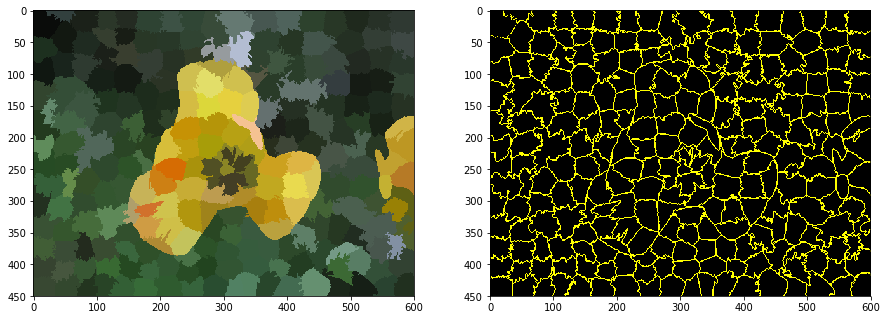

In [ ]:
segments = segmentation.slic(imgdata, n_segments=250,compactness=0.00000000000000001,convert2lab=False)
spix = color.label2rgb(segments, imgdata , kind='avg')

fig, ax  = plt.subplots(nrows=1, ncols=2 , figsize=(15, 8))
ax[0].imshow(spix )
ax[1].imshow(mark_boundaries(imgdata, segments))

In [ ]:
print(np.unique(annodata,return_counts=1))
print(segments.shape)
print(annodata.shape)
print(np.max(segments))

(array([0, 1, 2]), array([267085,    563,   2352]))
(450, 600)
(450, 600)
233


Any superpixel that contained at least one pixel labeled in the scrible mask is found, and considered to have a label similat to annotated data . The label for these superpixels will remain the same in all iterations.

These ground truth labels are stored in S_fg and S_bg, and shown below.

In [ ]:
S_img=np.zeros((np.max(segments)+1,3))
for s in range(len(S_img)):
    index=np.argwhere(segments==s)[0]
    S_img[s]= spix[index[0],index[1]]

In [ ]:
S_fg= np.unique(segments[np.where(annodata==1)])
S_bg= np.unique(segments[np.where(annodata==2)])

print(len(S_fg) , S_fg)
print(len(S_bg) , S_bg)


6 [ 90  97 108 114 126 127]
20 [ 20  21  33  37  38  46  47  51  58  59  66  76  77 156 166 168 178 185
 201 210]


### likelihood


likelihood represents how probable is the imgae given the label configurations. We estimated two multivariate Gaussian distributions for rgb values of each of foreground and background classes. Mean and covariance values for each of them is reported below:

The $likelihood$ function returns $p(S|F)$.

In [ ]:
var_fg= np.cov(S_img[S_fg].T )
mu_fg= np.mean(S_img[S_fg] , axis=0)
print('\n\nmean foreground= ',mu_fg , '\n\nvariance foreground =\n' ,var_fg)
P_fg= scipy.stats.multivariate_normal(mean=mu_fg, cov=var_fg)
    
var_bg= np.cov(S_img[S_bg].T )
mu_bg= np.mean(S_img[S_bg] , axis=0)
print('\nmean background= ',mu_bg , '\n\nvariance background =\n' ,var_bg)
P_bg= scipy.stats.multivariate_normal(mean=mu_bg, cov=var_bg)



mean foreground=  [153.33333333 137.83333333  20.5       ] 

variance foreground =
 [[1503.06666667 1124.86666667 -396.2       ]
 [1124.86666667  890.96666667 -277.9       ]
 [-396.2        -277.9         169.9       ]]

mean background=  [50.2  69.15 51.15] 

variance background =
 [[473.64210526 570.02105263 546.70526316]
 [570.02105263 756.13421053 660.55526316]
 [546.70526316 660.55526316 647.81842105]]


In [ ]:
def likelihood_P(S_img, F , P_fg , P_bg):
    
    p=1
    for i in range(len(S_img)):

        if (F[i]==1):
            p= p* np.float128(P_fg.pdf(S_img[i]))
        elif (F[i]==0):
            p= p* np.float128(P_bg.pdf(S_img[i])) 
        else:
            print('===ERROR=== There exist some undefined labels!')
    return p

### Adjacency matrix

Adjacency matrix, $A$, is a $(234,234)$ matrix which represents the neighbourhoood configuration. A is reported below:

In [ ]:
n = len(S_img)
A= np.identity(n)
for i in range( n ):
    for j in range(i+1 , n) :

        for k in np.atleast_2d(np.where(segments==i)).T :
        
            Neighbours = []
            Coord = k
            for dx in [-1,1,0]:
                for dy in [-1,1,0]:
                    X = Coord[0] + dx 
                    Y = Coord[1] + dy
                    Neighbours.append([X,Y])
            del Neighbours[-1]            
            
            
            for N in Neighbours:
                try:
                    if (segments[N[0],N[1]]==j):
                        A[i,j]=1
                        A[j,i]=1
                        break
                except IndexError:
                    pass


In [ ]:
print(np.all(A==A.T))
print(np.all(np.diag(A)))

with np.printoptions(edgeitems=10):
    print(A)

True
True
[[1. 1. 0. 0. 0. 0. 0. 0. 0. 0. ... 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0. ... 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0. ... 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 0. 0. 0. 0. ... 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0. 0. 0. 0. ... 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 1. 1. 0. 0. 0. ... 0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0. ... 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1. 0. ... 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. ... 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. ... 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. ... 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. ... 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. ... 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. ... 1. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0. ... 0. 0. 0. 0.

### Prior

Prior measures how probable each configuration is based on the neighbouring. It iterates over all set of two neighbours, and if those two neighbours have different labels, $p$ multiplies by a small value, making the prior probability smaller. 

$\beta$ indicates how much we force the neighbours to have same labels. Larger values of $\beta$, penalizes label mismatch stronger. In other words, by having larger $\beta$ values, superpixels are attracted to their neighbours more.

In [ ]:
def pr(B,f_i, f_j): 
    
    return np.float128(np.exp(-B * int(not(f_i==f_j)) ))

def prior(A, F ,B):
    p=1
    x,y=np.where(A==1)
    for i in range(len(x)):
        p= p * pr( B, F[x[i]] , F[y[i]] )
    return p

In [ ]:
prior(A, Ft ,10)

1.925928511003069582e-2884

This function will convert labels of superpixels to pixelwise mode, preparing it for displying.

In [ ]:
def visual(F,segments):
    pixlabel = np.ones((segments.shape[0],segments.shape[1])) *2
    for s in range(np.max(segments)+1):
        index=np.where(segments==s)
        pixlabel[index] = F[s]
    if(np.max(pixlabel>1)):
        print("===ERROR=== There exist some pixels with no labels assigned!")
    #plt.imshow(pixlabel,cmap='gray')
    return pixlabel

### Initialization - Distribution $\pi_{0}$

The segmentation results for two classes using GMMs are imported here to set it as the initial configuration. The groundtruth data is also added to the initialization configuration.

(array([0., 1.]), array([178107,  91893]))
(array([0., 1.]), array([168,  66]))


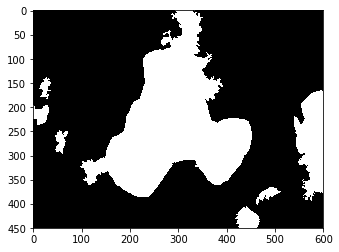

In [ ]:
pixlabel0 = np.loadtxt('labels_2seg.csv').reshape(height,width)
print(np.unique(pixlabel0, return_counts=True)) ## these are labels for each pixel


F0=np.zeros(len(S_img))
for s in range(len(S_img)):
    index=np.where(segments==s)
    l= np.mean(pixlabel0[index])
    if(l<0.5):
        F0[s]=0
    else:
        F0[s]=1

# to add the knowledge from supervised data
F0[S_bg]=0
F0[S_fg]=1
print(np.unique(F0, return_counts=True))

plt.imshow(visual(F0,segments),cmap='gray')

### Proposal Distribution

$proposal\_dist $ tweaks the previous configuration and generates another sample. $sigma$ denotes how much away cn the new sample be from the previous configuration. Sigma decreases over the time in the process of annealing.

When running the metropolis sampling, the generated samples kept having the likelihood of $zero$ even after 50000 iterations. I believe that it was because we were going far away from the initial configuration in our random walk, causing so many rejections. Therefore, I divided $sigma$ by 2; in order to make it generate samples closer to previous step.

In [ ]:
def sigma(t):
    return np.sqrt(3/(np.log(t+1)))/2

def proposal_dist(F, sigma , S_fg , S_bg):
    Ft = np.empty(F.shape)
    q10 = scipy.stats.norm.pdf(1,0,sigma)
    q11 = scipy.stats.norm.pdf(1,1,sigma)
    q00 = scipy.stats.norm.pdf(0,0,sigma)
    q01 = scipy.stats.norm.pdf(0,1,sigma)
    
    tweak0 = q10 / (q10+q00)
    tweak1 = q01 / (q01+q00)
    
    q=1
    for i in range(len(Ft)):
        x= np.random.uniform(0,1)
        if (i in S_fg): #can skip these conditions, letting the F[i] remain unchanged!
            Ft[i]=1 # pass
        elif (i in S_bg): #can skip these conditions, letting the F[i] remain unchanged!
            Ft[i]=0 # pass
        elif(F[i] and x<tweak1):
            Ft[i]=0
            q=q*q01
        elif(F[i] and x>=tweak1):
            Ft[i]=1
            q=q*q11
        elif(not(F[i]) and x<tweak0):
            Ft[i]=1
            q=q*q10
        elif(not(F[i]) and x>=tweak0):
            Ft[i]=0
            q=q*q00
    
    return Ft,q

# Metropolis Sampling

## Results for $\beta = 0.01$

**Metropolis Sampling** is running for 5000 iteration with $\beta=0.01$ and the results are displayes below:

In [ ]:
t=0
B=1e-2
Ftp=F0
F=np.atleast_2d(F0)
P_FtpS = prior(A, F0 ,B) * likelihood_P(S_img, F0 , P_fg , P_bg)


t=1
for k in range(5000):
    
    Ft , qt = proposal_dist(Ftp, sigma(t) , S_fg , S_bg)
    P_FtS = prior(A, Ft ,B) * likelihood_P(S_img, Ft , P_fg , P_bg)
    
    if (P_FtS==0 and P_FtpS==0):
        u=0
    elif( not(P_FtS==0) and P_FtpS==0):
        u=1
    else:
        u=P_FtS/P_FtpS
    
    t=t+1
    landa = min ( 1 , u)
    
    #print(P_FtS,P_FtpS,u,  lik ,'\n' )
    
    x= np.random.uniform(0,1)
    if (x<landa): ## accept the new sample
        #save
        F= np.concatenate((F,np.atleast_2d(Ft)) , axis=0)
        # move on to new point
        P_FtpS = P_FtS
        Ftp= Ft


In [ ]:
F.shape

(1534, 234)

Text(0.5,1,'Final Segmentation')

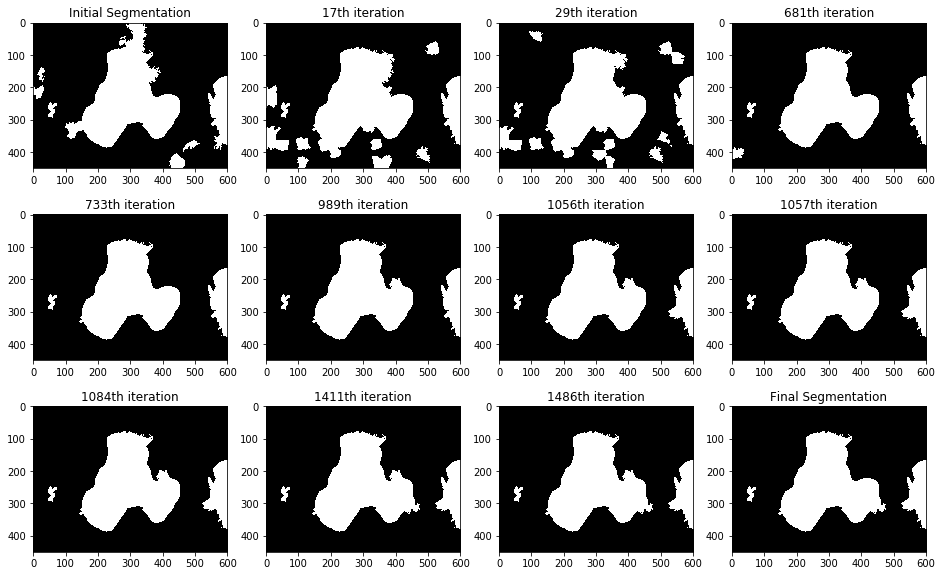

In [ ]:
indx= np.sort(np.random.choice( np.arange(1,len(F)-1,1) , 10 , replace=False ))

fig, ax  = plt.subplots(nrows=3, ncols=4 , figsize=(16, 10))

ax[0,0].imshow( visual(F[0],segments) , cmap='gray')
ax[0,0].set_title("Initial Segmentation")

for i in np.arange(1,11):
    ax[int(i/4) , i%4].imshow(visual(F[indx[i-1]],segments) , cmap='gray')
    ax[int(i/4) , i%4].set_title('%dth iteration' %(indx[i-1]))

ax[2,3].imshow(visual(F[-1],segments),cmap='gray')
ax[2,3].set_title('Final Segmentation')

The process had about 3500 rejections out of 5000 generated samples. 10 different segmentations in different timesteps are displayed. One can see that nodes are getting more and more attracted by their neighbours, resulting in correcting the wrong labels that can be seen in first row of figures.

## Results for $\beta = 10$
The process is repeated for different values of $\beta$.


In [ ]:
t=0
B=10
Ftp=F0
F=np.atleast_2d(F0)
P_FtpS = prior(A, F0 ,B) * likelihood_P(S_img, F0 , P_fg , P_bg)


t=1
for k in range(5000):
    
    Ft , qt = proposal_dist(Ftp, sigma(t) , S_fg , S_bg)
    P_FtS = prior(A, Ft ,B) * likelihood_P(S_img, Ft , P_fg , P_bg)
    
    if (P_FtS==0 and P_FtpS==0):
        u=0
    elif( not(P_FtS==0) and P_FtpS==0):
        u=1
    else:
        u=P_FtS/P_FtpS
    
    t=t+1
    landa = min ( 1 , u)
    
    #print(P_FtS,P_FtpS,u,  lik ,'\n' )
    
    x= np.random.uniform(0,1)
    if (x<landa): ## accept the new sample
        #save
        F= np.concatenate((F,np.atleast_2d(Ft)) , axis=0)
        # move on to new point
        P_FtpS = P_FtS
        Ftp= Ft


In [ ]:
F.shape

(1561, 234)

Text(0.5,1,'Final Segmentation')

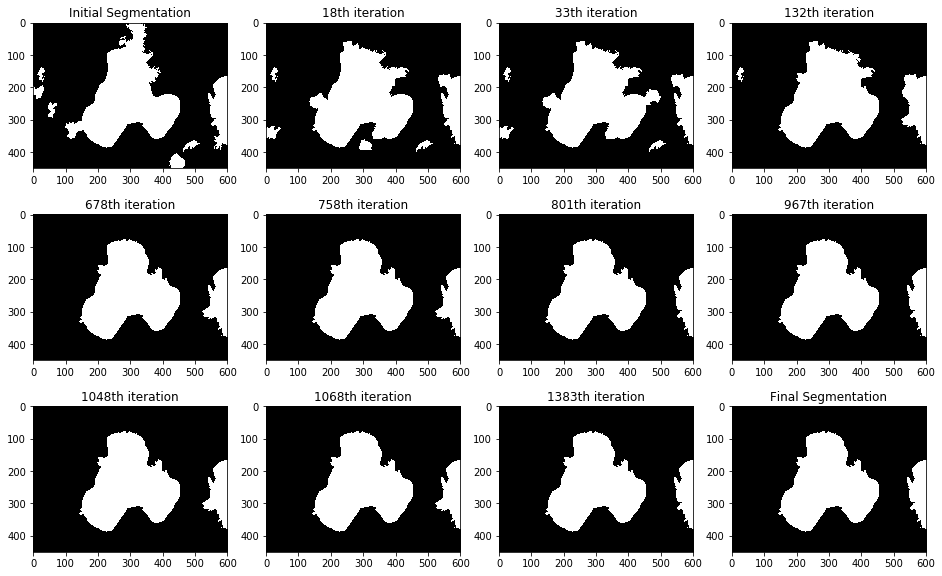

In [ ]:
indx= np.sort(np.random.choice( np.arange(1,len(F)-1,1) , 10 , replace=False ))

fig, ax  = plt.subplots(nrows=3, ncols=4 , figsize=(16, 10))

ax[0,0].imshow( visual(F[0],segments) , cmap='gray')
ax[0,0].set_title("Initial Segmentation")

for i in np.arange(1,11):
    ax[int(i/4) , i%4].imshow(visual(F[indx[i-1]],segments) , cmap='gray')
    ax[int(i/4) , i%4].set_title('%dth iteration' %(indx[i-1]))

ax[2,3].imshow(visual(F[-1],segments),cmap='gray')
ax[2,3].set_title('Final Segmentation')

## Results for $\beta = 50$

In [ ]:
t=0
B=50
Ftp=F0
F=np.atleast_2d(F0)
P_FtpS = prior(A, F0 ,B) * likelihood_P(S_img, F0 , P_fg , P_bg)


t=1
for k in range(10000):
    
    Ft , qt = proposal_dist(Ftp, sigma(t) , S_fg , S_bg)
    P_FtS = prior(A, Ft ,B) * likelihood_P(S_img, Ft , P_fg , P_bg)
    
    if (P_FtS==0 and P_FtpS==0):
        u=0
    elif( not(P_FtS==0) and P_FtpS==0):
        u=1
    else:
        u=P_FtS/P_FtpS
    
    t=t+1
    landa = min ( 1 , u)
    
    #print(P_FtS,P_FtpS,u,  lik ,'\n' )
    
    x= np.random.uniform(0,1)
    if (x<landa): ## accept the new sample
        #save
        F= np.concatenate((F,np.atleast_2d(Ft)) , axis=0)
        # move on to new point
        P_FtpS = P_FtS
        Ftp= Ft


In [ ]:
F.shape

(1, 234)

No better sample found after 5000 iterations.

## Results for $\beta = 10^{-5}$

In [ ]:
t=0
B=1e-10
Ftp=F0
F=np.atleast_2d(F0)
P_FtpS = prior(A, F0 ,B) * likelihood_P(S_img, F0 , P_fg , P_bg)


t=1
for k in range(10000):
    
    Ft , qt = proposal_dist(Ftp, sigma(t) , S_fg , S_bg)
    P_FtS = prior(A, Ft ,B) * likelihood_P(S_img, Ft , P_fg , P_bg)
    
    if (P_FtS==0 and P_FtpS==0):
        u=0
    elif( not(P_FtS==0) and P_FtpS==0):
        u=1
    else:
        u=P_FtS/P_FtpS
    
    t=t+1
    landa = min ( 1 , u)
    
    #print(P_FtS,P_FtpS,u,  lik ,'\n' )
    
    x= np.random.uniform(0,1)
    if (x<landa): ## accept the new sample
        #save
        F= np.concatenate((F,np.atleast_2d(Ft)) , axis=0)
        # move on to new point
        P_FtpS = P_FtS
        Ftp= Ft

Text(0.5,1,'Final Segmentation')

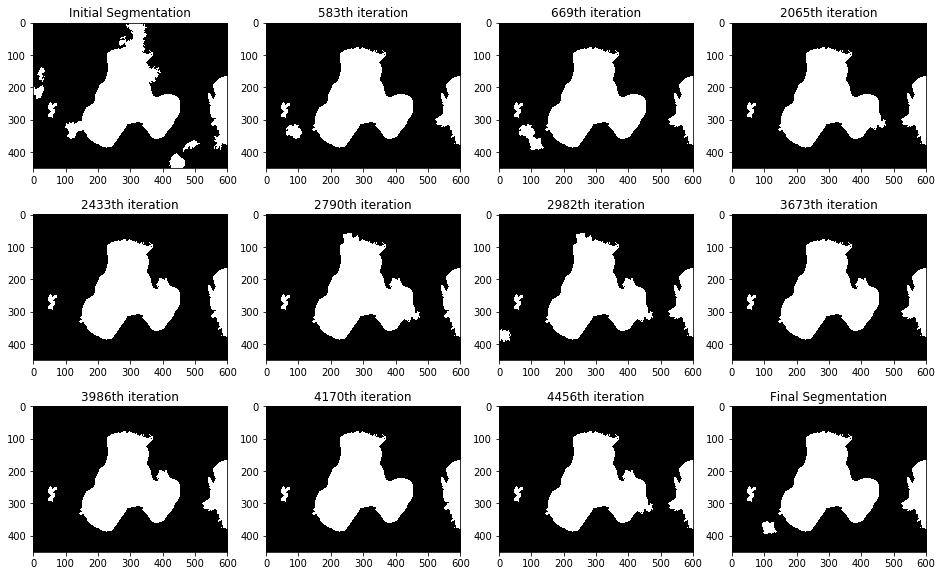

In [ ]:
indx= np.sort(np.random.choice( np.arange(1,len(F)-1,1) , 10 , replace=False ))

fig, ax  = plt.subplots(nrows=3, ncols=4 , figsize=(16, 10))

ax[0,0].imshow( visual(F[0],segments) , cmap='gray')
ax[0,0].set_title("Initial Segmentation")

for i in np.arange(1,11):
    ax[int(i/4) , i%4].imshow(visual(F[indx[i-1]],segments) , cmap='gray')
    ax[int(i/4) , i%4].set_title('%dth iteration' %(indx[i-1]))

ax[2,3].imshow(visual(F[-1],segments),cmap='gray')
ax[2,3].set_title('Final Segmentation')

### discuss the effect of $\beta$
I tried $\beta = 10^{-5} , 0.01 , 10 , 50 $.

It can be seen that larger values $\beta$ results in better segmentation. Larger values of $\beta$, penalizes label mismatch for neighbouring nodes stronger that smaller values of $\beta$. Therefore, it removes the islands that are labeled uncorrectly. 

However, too large values of $\beta$ put very small prior on configurations having unequal labels for neighbours, forcing them to take same labels. As a result, the joint probability $p(S,F)$ becomes too small and gets rejected. So the algorithm could not take even one step after 5000 iterations.

### Progress of proposal distribution

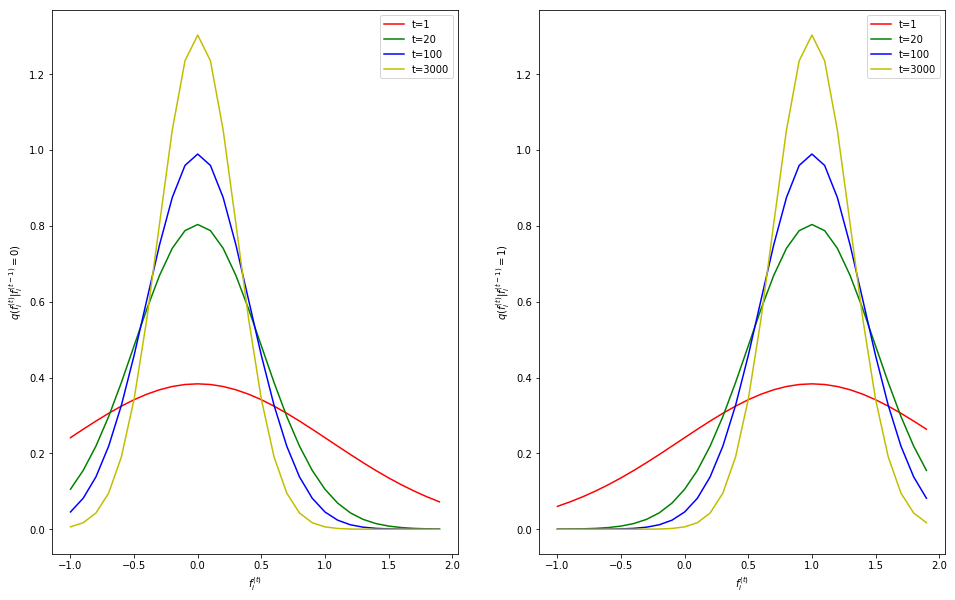

In [ ]:
x=np.arange(-1,2,0.1)

fig, ax  = plt.subplots(nrows=1, ncols=2 , figsize=(16, 10))

y0=scipy.stats.norm.pdf(x,0,sigma(1))
y1=scipy.stats.norm.pdf(x,0,sigma(20))
y2=scipy.stats.norm.pdf(x,0,sigma(100))
y3=scipy.stats.norm.pdf(x,0,sigma(3000))

ax[0].plot(x,y0,'r')
ax[0].plot(x,y1,'g')
ax[0].plot(x,y2,'b')
ax[0].plot(x,y3,'y')
ax[0].set_ylabel('$q(f_{i}^{(t)}|f_{i}^{(t-1)}=0)$')
ax[0].set_xlabel('$f_{i}^{(t)}$')
ax[0].legend(['t=1','t=20','t=100','t=3000'])


y0=scipy.stats.norm.pdf(x,1,sigma(1))
y1=scipy.stats.norm.pdf(x,1,sigma(20))
y2=scipy.stats.norm.pdf(x,1,sigma(100))
y3=scipy.stats.norm.pdf(x,1,sigma(3000))

ax[1].plot(x,y0,'r')
ax[1].plot(x,y1,'g')
ax[1].plot(x,y2,'b')
ax[1].plot(x,y3,'y')
ax[1].set_ylabel('$q(f_{i}^{(t)}|f_{i}^{(t-1)}=1)$')
ax[1].set_xlabel('$f_{i}^{(t)}$')
ax[1].legend(['t=1','t=20','t=100','t=3000'])




We can see that the proposal distribution gets more and more peaky, causing the random walk to take smaller steps.